## VAE 
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. This is equivalent to using MSE loss to regress the $\mu_\phi(z)$ to $x$.

## Hints

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)

## 1 Get and Inspect Data

In [1]:
!bash get_svhn.sh

mkdir: cannot create directory ‘data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  173M  100  173M    0     0  10.7M      0  0:00:16  0:00:16 --:--:-- 13.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61.2M  100 61.2M    0     0  7718k      0  0:00:08  0:00:08 --:--:-- 10.0M


In [3]:
from utils import *
import os, gzip, yaml, pickle, pickle, cv2
import torchvision.transforms as transforms

''' 
    - Train sample  : 73257
        - Train 60,000
        - Val 13,257
    - Test sample   : 26032
    - Numclasses    : 10
    - Mean          : [111.60893668 113.16127466 120.56512767] 
    - Std           : [50.49768174 51.2589843  50.24421614]

'''

X, y = load_svhn(train=True)    # (73257, 32, 32, 3), (73257, 1)
# X, y = load_svhn(train=False)  # (26032, 32, 32, 3), (26032, 1)

N,H,W,C = X.shape

sum = X.sum(axis=(0,1,2))
sum_sq = (X ** 2).sum(axis=(0,1,2))
mean = sum / (N*H*W)

_X = X - mean
var = (_X ** 2).sum(axis=(0,1,2)) / (N*H*W)
std = np.sqrt(var)

print(f'Mean: {mean} \nStd: {std}')

Mean: [111.60893668 113.16127466 120.56512767] 
Std: [50.49768174 51.2589843  50.24421614]


## 2 Train VAE Model On Small Dataset

Training model [vae] on device [cuda] with [128] samples
	Total epochs: [1000], total steps: 1000


Epoch 1000: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s, loss=168, loss recon=77.1, loss kl=45.3]     


(100, 32, 32, 3) (100, 32, 32, 3) (100, 32, 32, 3)
(1000, 3) (1000, 3)


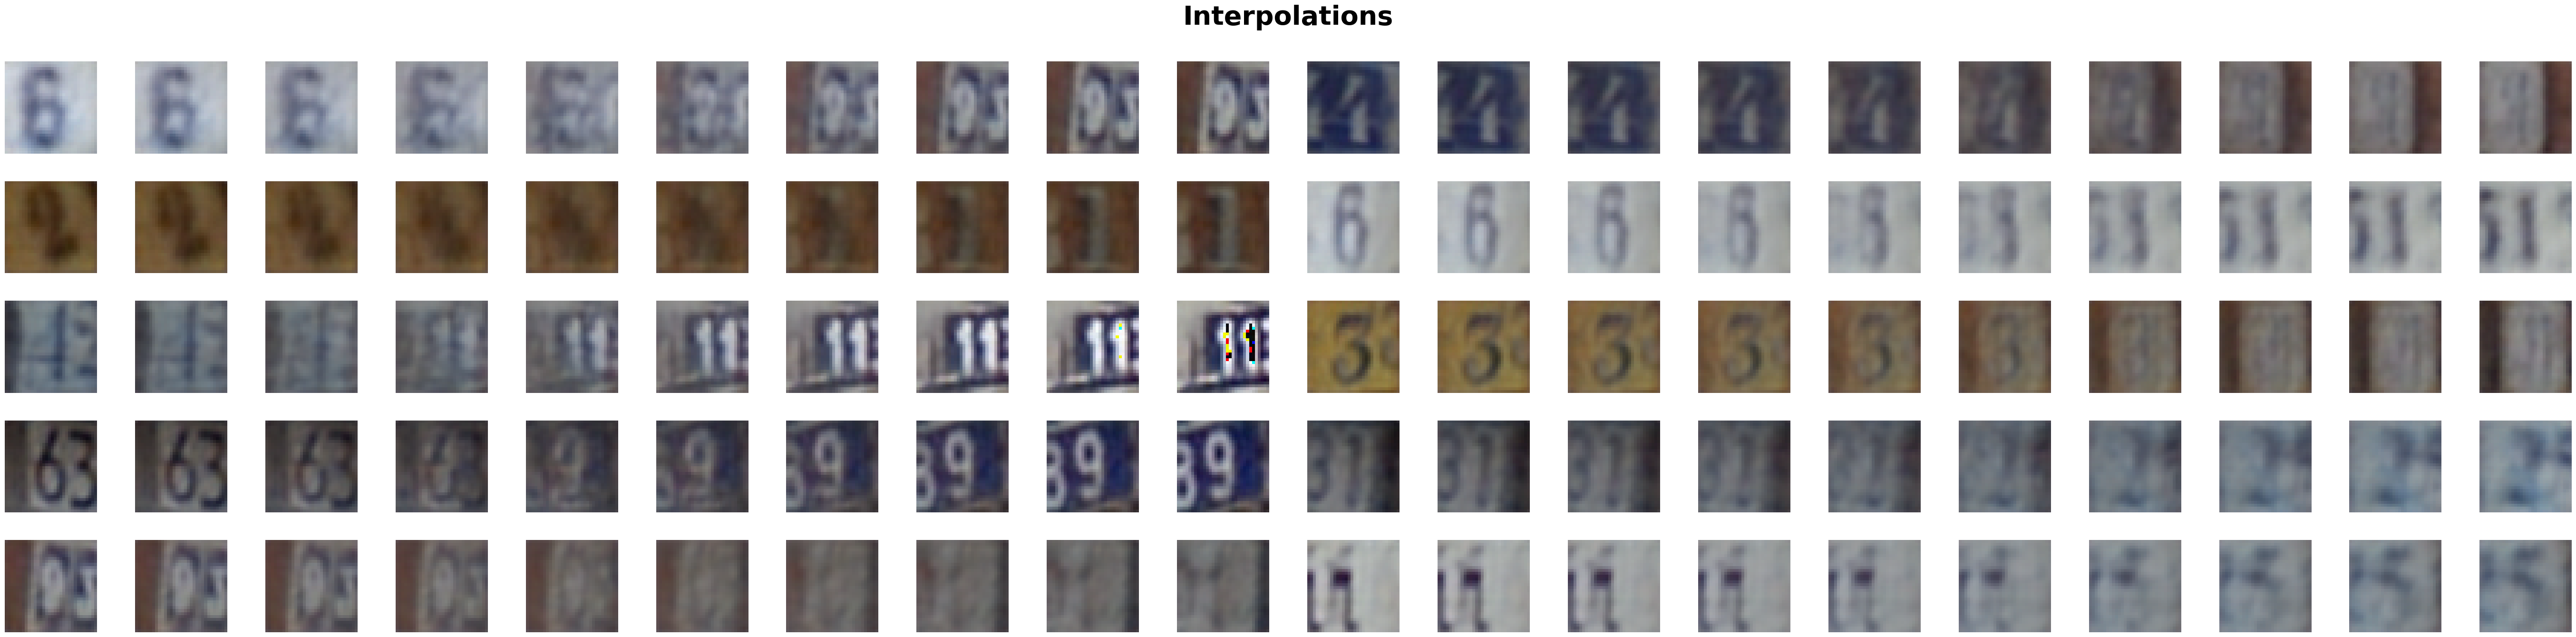

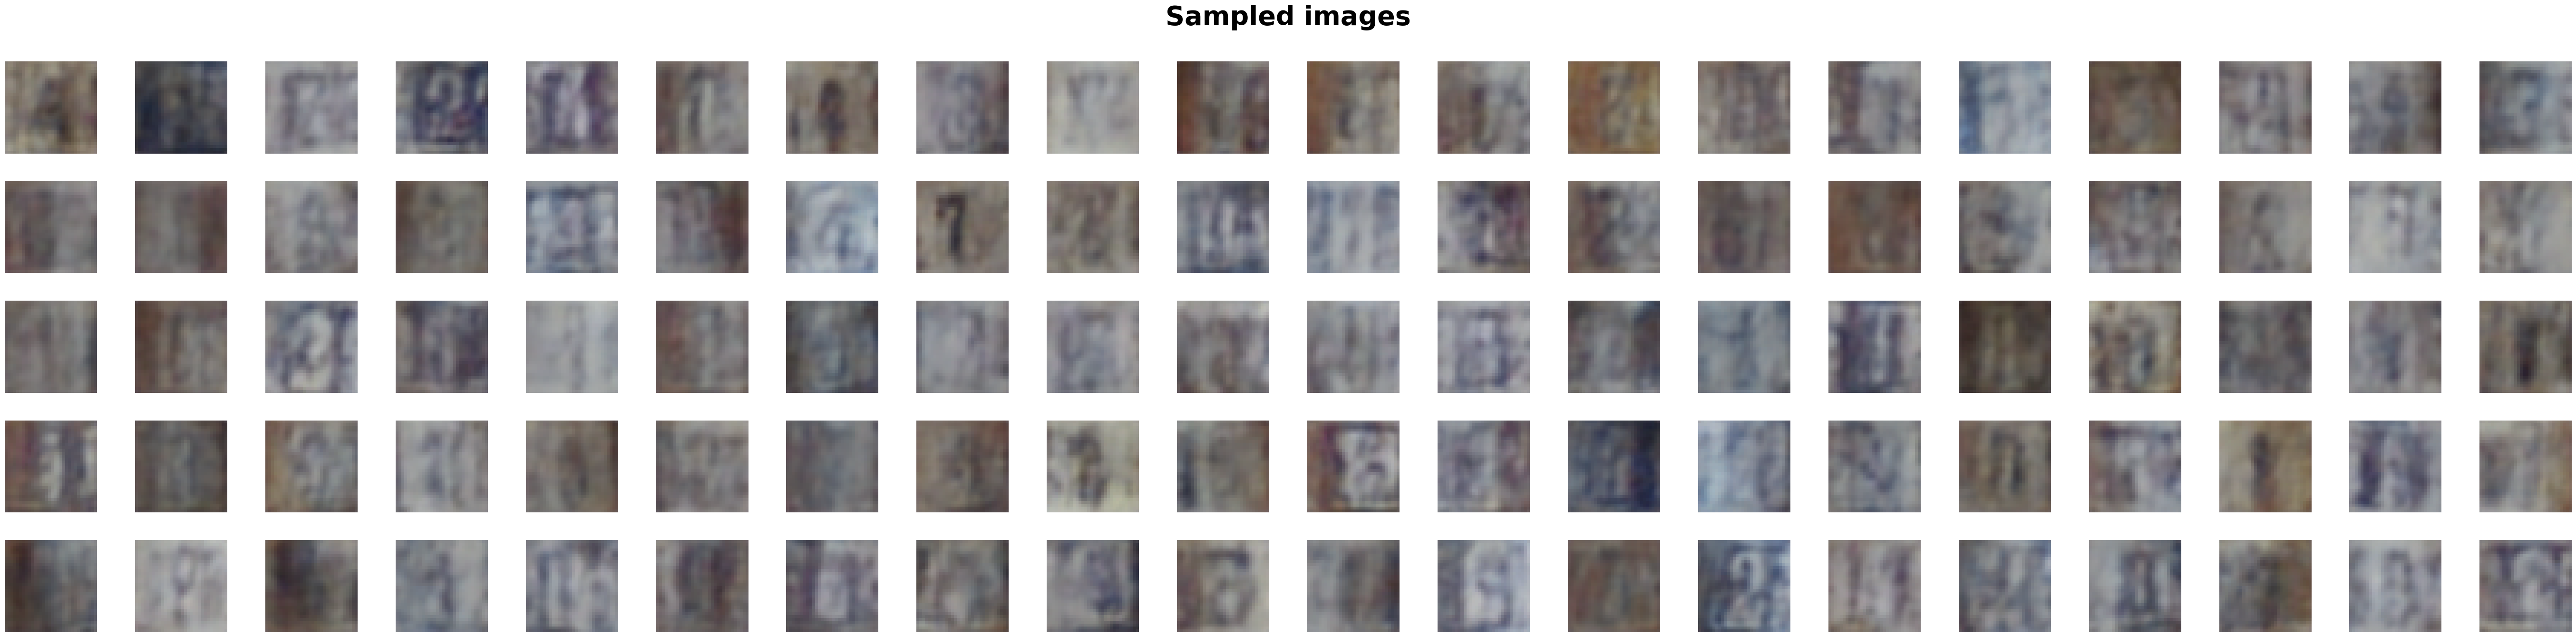

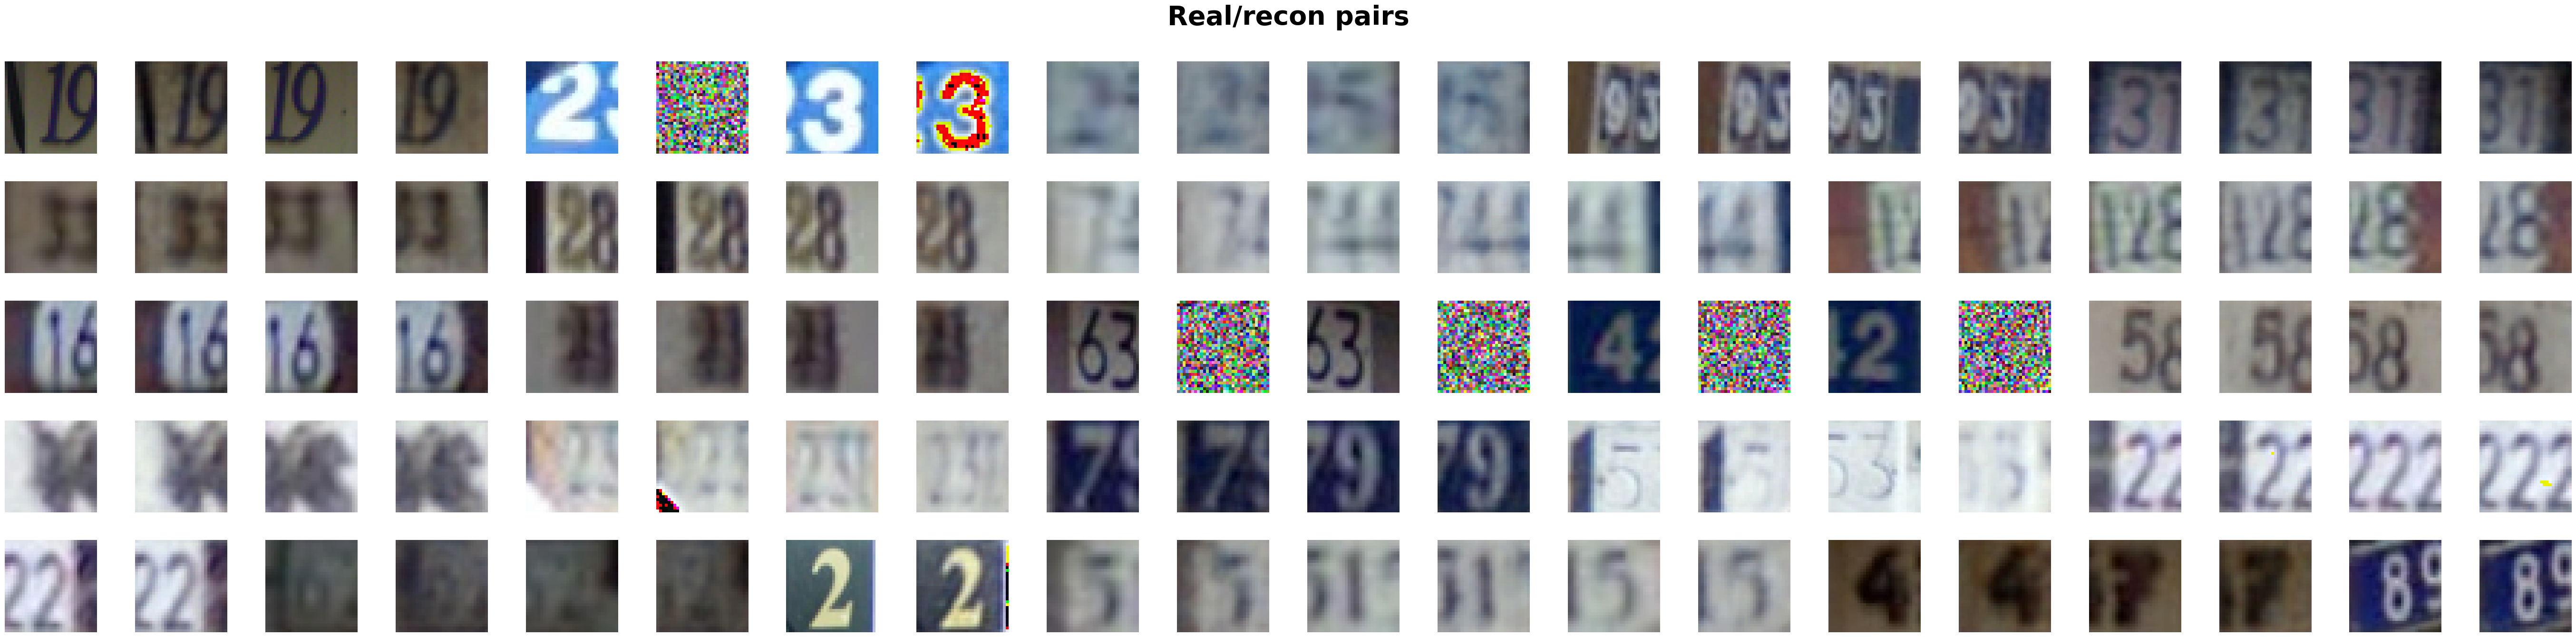

In [1]:
from utils import *
from dataset import *
from vae import *
from torch.utils.data import DataLoader
from tqdm import tqdm

config = {
    'bz'        : 128, 
    'lr'        : 1e-3,
    'kl_weight' : 2,
    'epochs'    : 1000,
    'remark'    : 'vae',
    'tiny_ds'   : True
}

''' Define transforms '''
mean, std = np.array([111.608, 113.161, 120.565]), np.array([50.497, 51.258, 50.244])
normalize = transforms.Normalize(mean, std)
totensor = transforms.ToTensor()
flip = transforms.RandomHorizontalFlip()

input_transform = transforms.Compose([totensor, normalize])

''' Get data '''
loader_train, loader_test = get_svhn_loaders(input_transform, config)

''' Train model '''
model = VAE(kl_weight=config['kl_weight'])
train_history, test_history = train(model, loader_train, loader_test, config)


''' Inspect model '''
imgs = next(iter(loader_train))
samples = sample_and_visualize(model)
interpolations = interpolate_and_visualize(imgs, model)
imgs_and_recons = decode_and_visualize(imgs, model)

# train_history, test_history, samples, imgs_and_recons, interpolations \
#     = problem_vae()


## 3 Train VAE on the entire dataset

Training model [vae_full] on device [cuda] with [73344] samples
	Total epochs: [20], total steps: 11460


Epoch 20: 100%|██████████| 20/20 [39:21<00:00, 118.05s/it, loss=341, loss recon=298, loss kl=43.3]


Final -ELBO: 293.9282, Recon Loss: 252.4923, KL Loss: 41.4360


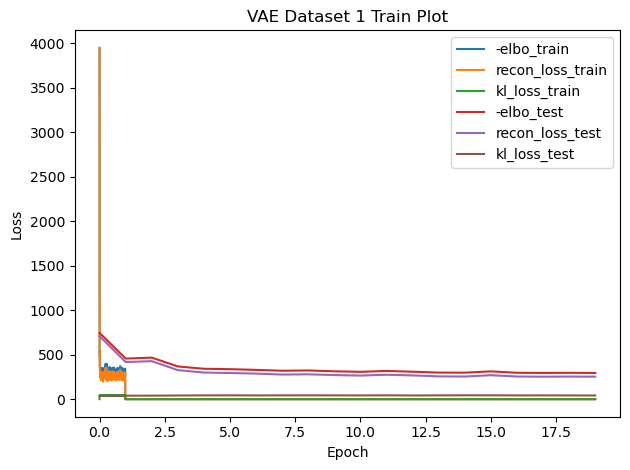

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


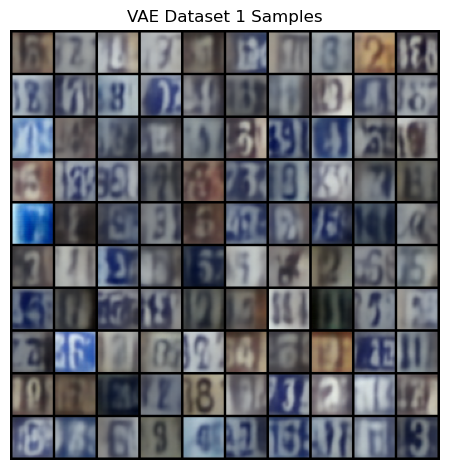

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


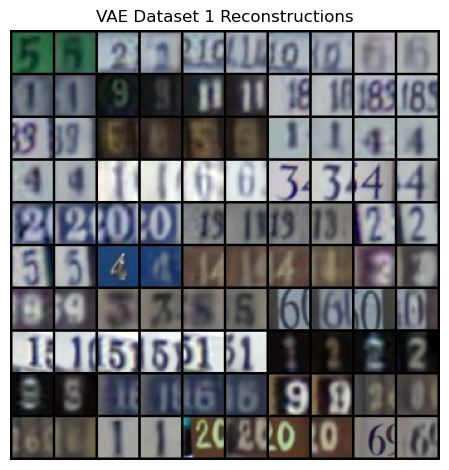

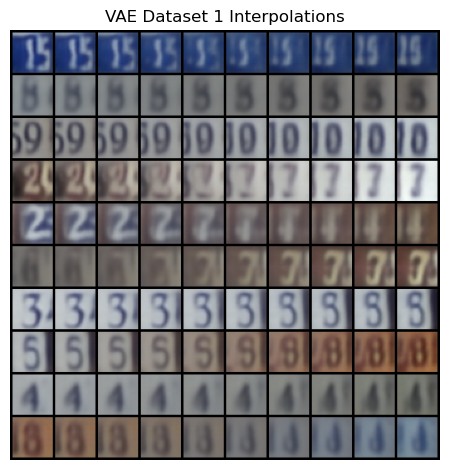

In [1]:
from utils import *
from dataset import *
from vae import *
from torch.utils.data import DataLoader
from tqdm import tqdm

config = {
    'bz'        : 128, 
    'lr'        : 1e-3,
    'kl_weight' : 5,
    'epochs'    : 20,
    'remark'    : 'vae_full',
    'tiny_ds'   : False
}

''' Define transforms '''
mean, std = np.array([111.608, 113.161, 120.565]), np.array([50.497, 51.258, 50.244])
normalize = transforms.Normalize(mean, std)
totensor = transforms.ToTensor()
flip = transforms.RandomHorizontalFlip()

input_transform = transforms.Compose([totensor, normalize])

''' Get data '''
loader_train, loader_test = get_svhn_loaders(input_transform, config)

''' Train model '''
model = VAE(kl_weight=config['kl_weight'])
train_history, test_history = train(model, loader_train, loader_test, config)

''' Inspect model, make deliverables'''
# max_loss = 800
# train_history[train_history > max_loss] = max_loss
# test_history[test_history > max_loss] = max_loss

imgs = next(iter(loader_test))
samples = sample_and_visualize(model, view=False)
imgs_and_recons = decode_and_visualize(imgs, model, view=False)
interpolations = interpolate_and_visualize(imgs, model, view=False)

vae_save_results((train_history, test_history, samples, imgs_and_recons, interpolations))

## Visualize Trained Model

Final -ELBO: 293.9282, Recon Loss: 252.4923, KL Loss: 41.4360


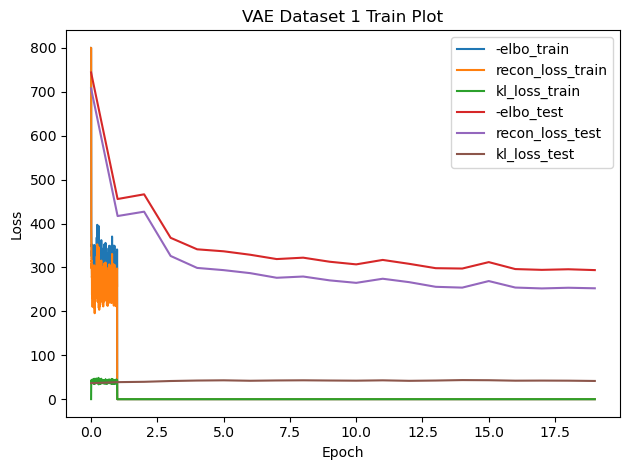

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


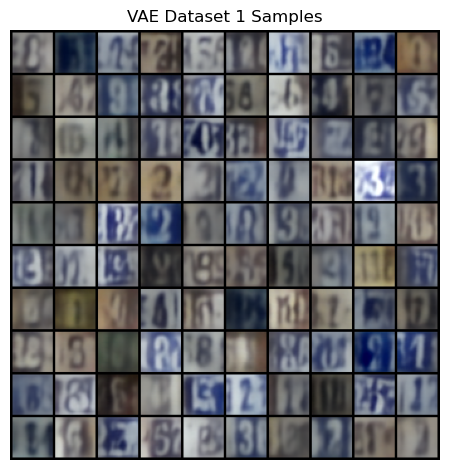

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


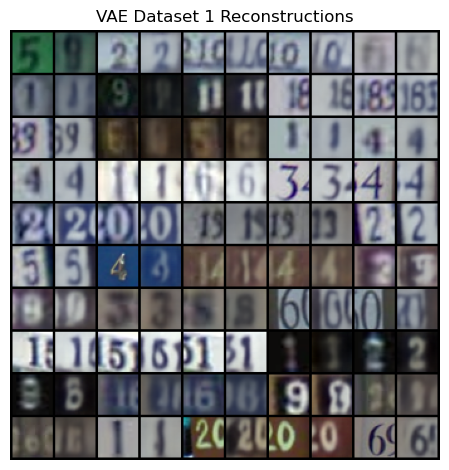

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


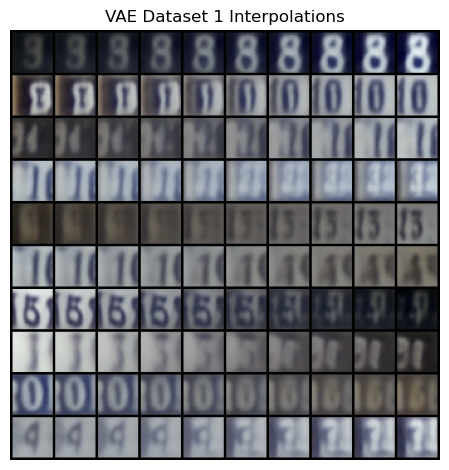

In [2]:
import pickle
from utils import *
from dataset import *
from vae import *
from torch.utils.data import DataLoader
from tqdm import tqdm


config = {'bz': 128, 'tiny_ds': False}

''' Define transforms '''
mean, std = np.array([111.608, 113.161, 120.565]), np.array([50.497, 51.258, 50.244])
normalize = transforms.Normalize(mean, std)
totensor = transforms.ToTensor()
flip = transforms.RandomHorizontalFlip()

input_transform = transforms.Compose([totensor, normalize])

''' Get data '''
loader_train, loader_test = get_svhn_loaders(input_transform, config)

''' Load model and records '''
model = VAE()
fname = './trained_model/vae_full_02-23_20:40.pt'
model.load_state_dict(torch.load(fname))

fname = './trained_model/vae_full_02-23_20:40_record.pickle'
with open(fname, 'rb') as f:
    train_history, test_history = pickle.load(f)

max_loss = 800
train_history[train_history > max_loss] = max_loss
test_history[test_history > max_loss] = max_loss

''' Visualization '''
imgs = next(iter(loader_test))
samples = sample_and_visualize(model, view=False)
imgs_and_recons = decode_and_visualize(imgs, model, view=False)
interpolations = interpolate_and_visualize(imgs, model, view=False)

vae_save_results((train_history, test_history, samples, imgs_and_recons, interpolations))